In [251]:
import re
import nltk

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [252]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/dip07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dip07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [253]:
df_train = pd.read_csv("data/medical_tc_train.csv")
df_test = pd.read_csv("data/medical_tc_test.csv")
df_train.loc[df_train['condition_label'] == 5, 'condition_label'] = 0.0
df_test.loc[df_test['condition_label'] == 5, 'condition_label'] = 0.0
print("The total number of training data is: %d" %(df_train.shape[0]))
print("The total number of testing data is: %d" %(df_test.shape[0]))

The total number of training data is: 11550
The total number of testing data is: 2888


In [254]:
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"✅ Combined dataset size: {df.shape[0]} samples")

✅ Combined dataset size: 14438 samples


In [ ]:
#Cleaning text
def clean_text(t):
    """Lowercase, remove non-alphanumeric chars (keep punctuation minimally)."""
    t = str(t).lower()
    t = re.sub(r'[^a-z0-9\s\-.,]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t
df["medical_abstract"] = df["medical_abstract"].apply(clean_text)
df.head(1)

,condition_label,medical_abstract
0,0,tissue changes around loose prostheses. a cani...


In [ ]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')).union(
        {'patient', 'doctor', 'report', 'normal', 'exam'}
    )
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]  # remove punctuation/numbers
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)

df["medical_abstract"] = df["medical_abstract"].apply(preprocess_text)
df.head(1)

,condition_label,medical_abstract
0,0,tissue change around loose prosthesis canine m...


In [258]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),     # capture meaningful medical phrases
    max_df=0.5,            # remove very common words
    min_df=5,              # ignore rare noise words
    sublinear_tf=True,     # scale term frequencies
    use_idf=True,          # emphasize rare informative terms
    max_features=3000      # limit to the most relevant terms
)
X = tfidf.fit_transform(df['medical_abstract'])
y = df['condition_label']

In [259]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_test.shape[0]}")
print(f"Test set size: {X_valid.shape[0]}")

Training set size: 10106
Validation set size: 2166
Test set size: 2166


In [260]:
accuracy_list = []
for i in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i, metric='cosine')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    accuracy_list.append(accuracy)

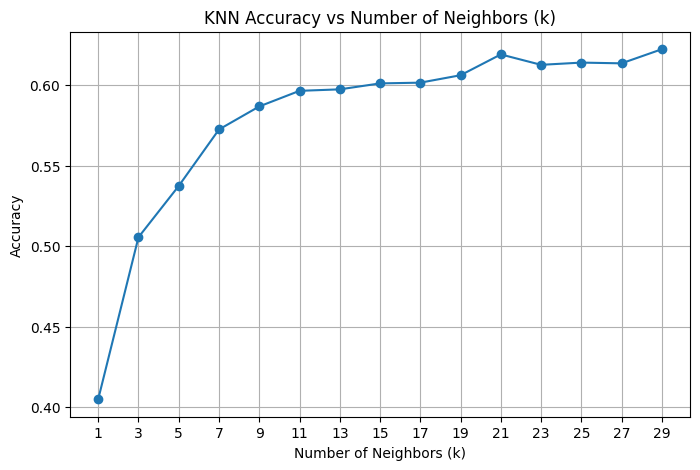

Max Accuracy: 0.6223453370267775
K: 29


In [261]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,30, 2), accuracy_list, marker='o')
plt.title("KNN Accuracy vs Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(range(1,30, 2))
plt.show()
print("Max Accuracy:", accuracy_score(y_valid, y_pred))
k = accuracy_list.index(max(accuracy_list)) * 2 + 1
print("K:", k)

In [262]:
accuracy_list

[0.4048938134810711,
 0.5055401662049861,
 0.5373961218836565,
 0.5724838411819021,
 0.5867959372114496,
 0.5964912280701754,
 0.5974145891043398,
 0.6011080332409973,
 0.6015697137580794,
 0.6061865189289012,
 0.6191135734072022,
 0.6126500461680517,
 0.6140350877192983,
 0.6135734072022161,
 0.6223453370267775]

In [263]:
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(X_train, y_train)
# 
y_train_pred = knn.predict(X_train)
print("\n✅ Train Performance:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))


✅ Train Performance:
Accuracy: 0.6462497526222046


In [264]:
knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn.fit(X_train, y_train)
# 
y_test_pred = knn.predict(X_test)
print("\n✅ Test Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))


✅ Test Performance:
Accuracy: 0.6089566020313942


In [265]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.58      0.48      0.52       753
           1       0.67      0.79      0.73       453
           2       0.48      0.45      0.47       209
           3       0.55      0.44      0.49       269
           4       0.65      0.80      0.72       482

    accuracy                           0.61      2166
   macro avg       0.59      0.59      0.59      2166
weighted avg       0.60      0.61      0.60      2166



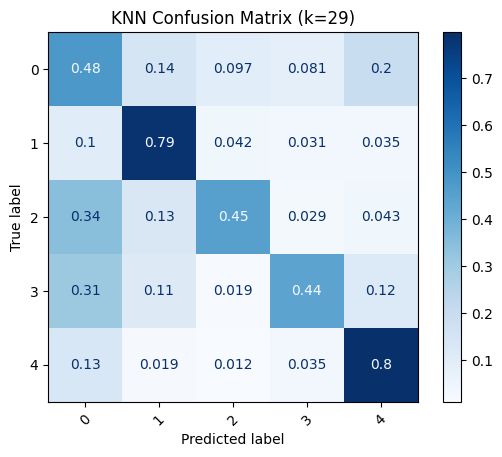

In [266]:
cm = confusion_matrix(y_test, y_test_pred, labels=knn.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"KNN Confusion Matrix (k={k})")
plt.show()